# <font color='darkblue'>ASTR 21100 

# <font color='darkblue'>"Computational Techniques in Astrophysics"

## <font color='darkblue'>Sampling multi-dimensional distributions with MCMC
## <font color='darkblue'>Using MCMC in maximum likelihood/Bayesian analysis
    
## <font color='darkblue'>Instructor: Andrey Kravtsov

### <font color='darkblue'>email: kravtsov@uchicago.edu

In [73]:
import numpy as np 

# use jupyter "magic" command to tell it to embed plot into the notebook 
import matplotlib.pyplot as plt
%matplotlib inline

# the following commands make plots look better
# try to experiment with these parameters to see what they do
def plot_pretty(dpi = 200, fontsize=10):
    plt.rcParams['figure.dpi']= dpi
    plt.rc("savefig", dpi=dpi)
    plt.rc('font', size=fontsize)
    plt.rc('xtick', direction='in') 
    plt.rc('ytick', direction='in')
    plt.rc('xtick.major', pad=5) 
    plt.rc('xtick.minor', pad=5)
    plt.rc('ytick.major', pad=5) 
    plt.rc('ytick.minor', pad=5)
    plt.rc('lines', dotted_pattern = [2., 2.]) # this makes lines plotted by plt.grid much nicer looking
    #if you don't have LaTeX installed on your laptop and this statement 
    # generates error, comment it out
    plt.rc('text', usetex=True)

plot_pretty()

### <font color='darkblue'>Sampling a 2d Gaussian

Now let's sample a 2-dimensional Gaussian, $p_{\rm G}(x_1, x_2)$, where specific values of the parameters $x_1$ and $x_2$ can be thought of as *coordinates of a point in the 2d plane $x_1-x_2$*. 
    
If the Gaussian is characterized by the mean value in two variables, $\vec{\mu}=[\mu_{x_1},\mu_{x_2}]$, rms values, $\sigma_{x_1}$, $\sigma_{x_2}$ and correlation coefficient, $r$. 

$$p_{\rm G}(x_1,x_2) =\frac{1}{2\pi\sigma_{x_1}\sigma_{x_2}\sqrt{1-r^2}}\,\exp\left\{-\frac{1}{2(1-r^2)}\left[\frac{(x_1-\mu_{x_1})^2}{\sigma_{x_1}^2}-2r\frac{(x_1-\mu_{x_1})}{\sigma_{x_1}}\frac{(x_2-\mu_{x_2})}{\sigma_{x_2}}+\frac{(x_2-\mu_{x_2})^2}{\sigma_{x_2}^2}\right]\right\},$$

Usually, the variances and correlation coefficient are put together into the ***covariance matrix***: 

$$
\mathbf{C}=\left(
  \begin{array}{cc}
   \sigma^2_{x_1} & r\sigma_{x_1}\sigma_{x_2} \\
     r\sigma_{x_1}\sigma_{x_2} & \sigma^2_{x_2}  \\
  \end{array} \right)
$$

Let's specify a 2d Gaussian with $\mu_{x_1}=\mu_{x_2}=0$, $\sigma_{x_1}=\sigma_{x_2}=1$ and $r=0.95$. 

### <font color='darkblue'>Multivariate (multi-dimensional) Gaussian distribution


A $d$-dimensional Gaussian distribution is <a href="https://en.wikipedia.org/wiki/Multivariate_normal_distribution">defined as</a> 

$$p_{\rm G}(x_1,\ldots,x_d) =\frac{1}{\sqrt{(2\pi)^d\vert C\vert}}\,\exp\left[-\frac{1}{2}(\vec{x}-\vec{\mu})^T\mathbf{C}^{-1}(\vec{x}-\vec{\mu})\right],$$

where $\vec{\mu}$ is a vector of mean values and  $\mathbf{C}$ is covariance matrix ($\vert C\vert$ is its determinant). 

We will work with  $\ln$ of this distribution:
$$\ln p_{\rm G}(x_1,\ldots,x_d) = -\frac{1}{2}(\vec{x}-\vec{\mu})^T\mathbf{C}^{-1}(\vec{x}-\vec{\mu}) -\frac{d}{2}\ln 2\pi - \frac{1}{2}\ln\vert C\vert.$$

We will work with  $\ln$ of the Gaussian distribution, neglecting the factor in front of exponent):
$$\ln p_{\rm G}(x_1,\ldots,x_d) = -\frac{1}{2}(\vec{x}-\vec{\mu})^T\mathbf{C}^{-1}(\vec{x}-\vec{\mu})$$

In [74]:
def lngauss_nd(x, means, icov):
    """
    ln of N-dimensional unnormalized Gaussian pdf (neglecting the constant in front of exp)
    
    Parameters:
    -----------
    x - real 1d numpy vector of size ndim
        position of a sample in ndim-dimensional space
    means - real 1d numpy vector of size ndim
        mean values of the Gaussian in each coordinate
    icov - real numpy array of size [ndim x ndim]
        inverse covariance matrix of the Gaussian
        
    Returns:
    --------
    
    a real number 
        ln(Gaussian)
    """
    diff = x - means
    
    return -0.5 * np.dot(diff.T, np.dot(icov, diff)) 

In [75]:
# you don't need to review or understand this code
# this is a function for plotting 2d distribution of points as a histogram that will be used for plots below

import scipy.optimize as opt
from matplotlib.colors import LogNorm

def conf_interval(x, pdf, conf_level):
    return np.sum(pdf[pdf > x])-conf_level

def plot_2d_dist(x,y, xlim, ylim, nxbins, nybins, figsize=(5,5), 
                cmin=1.e-4, cmax=1.0, smooth=None, xpmax=None, ypmax=None, 
                log=False, weights=None, xlabel='x', ylabel='y', 
                clevs=None, fig_setup=None, savefig=None):
    """
    construct and plot a binned, 2d distribution in the x-y plane 
    using nxbins and nybins in x- and y- direction, respectively
    
    log = specifies whether logged quantities are passed to be plotted on log-scale outside this routine
    """
    if fig_setup is None:
        fig, ax = plt.subplots(figsize=figsize)
        plt.ylabel(ylabel)
        plt.xlabel(xlabel)
        plt.xlim(xlim[0], xlim[1])
        plt.ylim(ylim[0], ylim[1])
    else:
        ax = fig_setup
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_xlim(xlim); ax.set_ylim(ylim)

    if xlim[1] < 0.: ax.invert_xaxis()

    if weights is None: weights = np.ones_like(x)
    H, xbins, ybins = np.histogram2d(x, y, weights=weights, bins=(np.linspace(xlim[0], xlim[1], nxbins),np.linspace(ylim[0], ylim[1], nybins)))
    
    H = np.rot90(H); H = np.flipud(H); 
             
    X,Y = np.meshgrid(xbins[:-1],ybins[:-1]) 

    if smooth != None:
        from scipy.signal import wiener
        H = wiener(H, mysize=smooth)
        
    H = H/np.sum(H)        
    Hmask = np.ma.masked_where(H==0,H)
    
    if log:
        X = np.power(10.,X); Y = np.power(10.,Y)

    pcol = ax.pcolormesh(X, Y,(Hmask), vmin=cmin*np.max(Hmask), vmax=cmax*np.max(Hmask), cmap=plt.cm.BuPu, norm = LogNorm(), linewidth=0., rasterized=True)
    pcol.set_edgecolor('face')
    
    # plot contours if contour levels are specified in clevs 
    if clevs is not None:
        lvls = []
        for cld in clevs:  
            sig = opt.brentq( conf_interval, 0., 1., args=(H,cld) )   
            lvls.append(sig)
        
        ax.contour(X, Y, H, linewidths=(1.0,0.75, 0.5, 0.25), colors='black', levels = sorted(lvls), 
                norm = LogNorm(), extent = [xbins[0], xbins[-1], ybins[0], ybins[-1]])
    if xpmax is not None:
        ax.scatter(xpmax, ypmax, marker='x', c='orangered', s=20)
    if savefig:
        plt.savefig(savefig,bbox_inches='tight')
    if fig_setup is None:
        plt.show()
    return


This is a simple MCMC implementation copied from the previous notebook. It is written in a way that allows sampling in any number of dimensions. 

In [76]:
def mcmc_simple(x0, nsteps, step, logpdf, *args):
    """
    a simple implementation of the Metropolis MCMC algorithm
    implements steps using a uniformly distributed random number in the range [-step,step]

    Parameters:
    -----------
    x0:     1d numpy array of floats (size = number of dimensions), initial point
    nsteps: integer, the number of steps to make
    step:   float, step size normalization
    logpdf: Python function object for the ln(pdf) function
    args:   list, a list of arguments to pass to logpdf (can be empty)
    
    Returns:
    --------
    chain: list of size nsteps, containing all recorded steps 
    """
    x = x0 
    nparams = np.size(x0) # dimensionality of distribution we are sampling
    fnow = logpdf(x, *args) # compute current value of ln(pdf)
    
    chain = [] # initialize chain list
    for nstep in range(nsteps):
        xtry = x + step * np.random.uniform(-1, 1., size=nparams)
        ftry = logpdf(xtry, *args)
        if ftry > fnow:
            x = xtry
            fnow = ftry
        else: 
            u = np.log(np.random.uniform())
            if u < ftry-fnow:
                x = xtry
                fnow = ftry
        chain.append(x)
        
    return chain

In [77]:
def auto_corr_func(timeseries, lagmax):
    """
    compute auto correlation function
    """
    ts = np.asarray(timeseries)
    n = np.size(ts) - 1
    ts -= np.mean(ts) # set to mean 0
    corr_func = np.zeros(lagmax)
    # compute xi(j) for different j
    for j in range(lagmax):
        # sum of ts[t+dt]*ts[t]
        corr_func[j] = (np.dot(timeseries[0:n-j],timeseries[j:n])) 
    if (corr_func[0] > 0):
        corr_func /= corr_func[0] # normalize
    return corr_func


def compute_tcorr(timeseries, maxcorr):
    """
    compute correlation time
    """
    timeseries = np.copy(timeseries)
    mean = np.mean(timeseries)
    corrfxn = auto_corr_func(timeseries,maxcorr)
    tau = np.sum(corrfxn)-1 # auto-correlation time
    var = np.var(timeseries)
    sigma = np.sqrt(var * tau / len(timeseries))
    return tau, mean, sigma


In [78]:
# define st deviations for the two dimension of the Gaussian and value of correlation coefficient
means = [0., 0.] # values of means of Gaussian pdf for 2 dimensions
s1, s2, r = 1.0, 1.0, 0.95

# covariance matrix of 2-dimensional Gaussian
cov = [[s1**2, r*s1*s2], [r*s1*s2, s2**2]]
# compute the inverse covariance matrix
icov = np.linalg.inv(cov)

In [79]:
ndim = 2 # dimensionality of the distribution
nsteps = 100000 # number of steps to make
x0 = np.random.rand(ndim) # initial position
step = 1. # step size

args = [means, icov] # parameters of the Gaussian
# run simple MCMC 
chain = np.asarray(mcmc_simple(x0, nsteps, step, lngauss_nd, *args))

Now we will plot the two variable samples (representing two dimensions) and will also plot contours that enclose 68.27% and 95.45% of the samples (aka 1-$\sigma$ and 2-$\sigma$ contours). 

/Users/panyue/opt/anaconda3/envs/py23/lib/python3.7/site-packages/ipykernel_launcher.py:51: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/Users/panyue/opt/anaconda3/envs/py23/lib/python3.7/site-packages/ipykernel_launcher.py:51: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
/Users/panyue/opt/anaconda3/envs/py23/lib/python3.7/site-packages/ipykernel_launcher.py:62: UserWarning: Log scale: values of z <= 0 have been masked


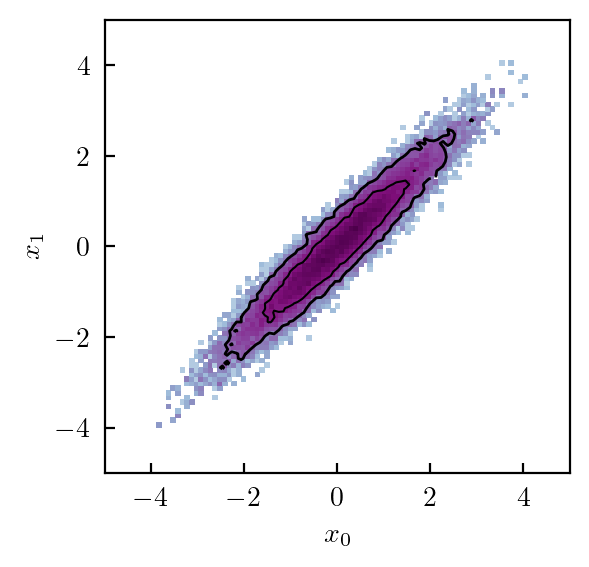

In [80]:
# define levels to plot (fractions of samples enclosed by the contours)
conflevs = [0.6827, 0.9545]

# plot distribution of MCMC samples as a 2d histogram with contours
# in the $x_0-x_1$ plane, where $x_0$ and $x_1$ are 2 Gaussian variables
# chain[:,0], chain[:,1] access sample values of two variables separately
plot_2d_dist(chain[:,0], chain[:,1], xlim=[-5,5], ylim =[-5,5], nxbins=100, nybins=100, 
             clevs=conflevs,  xlabel='$x_0$', ylabel='$x_1$', figsize=(3,3))

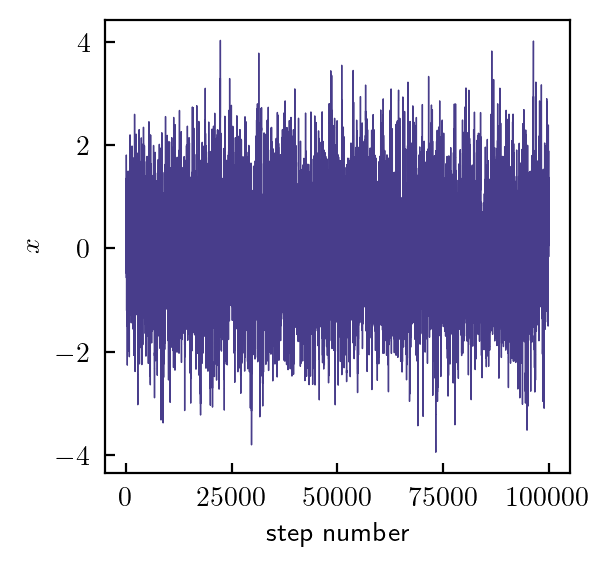

In [81]:
plot_trace(chain[:,1])

In [82]:
# compute tcorr
for i in range(ndim):
    tcorr = compute_tcorr(chain[:,i], 10000)[0]
    print('auto-correlation length for dimension {:d} = {:.3f}'.format(i, tcorr))

/Users/panyue/opt/anaconda3/envs/py23/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in sqrt


auto-correlation length for dimension 0 = -1.631
auto-correlation length for dimension 1 = -1.450


### <font color='darkblue'>A more difficult/realistic case: sampling of the Rosenbrock "banana" distribution

Rosenbrock distribution is described by the following equation in 2D (i.e. for two parameters $x$ and $y$): 

$$p_{\rm R}(x_1,x_2) = \exp\left[-c(b(x_2-x_1^2)^2 -(a-x_1)^2)\right], $$
    

which is often used for testing optimization and sampling algorithms, particularly with $a=1$, $b=100$ most often used. It has a global maximum at $(x_1,x_2)=(a,a^2)$ at which $p_{\rm R}(x_1,x_2)=1$, as is clear from the equation above. 

This function is frequently used for testing of sampling and optimization algorithms (we will discuss these next week) because this function is quite "difficult" despite its benign-looking functional form. The function spans a wide range of values over small change of parameters: it has a strongly "curved" ridge in the $x-y$ plane which extends  values to large values of $x$ and $y$. 

The function is named after Howard H. Rosenbrock, who introduced it as a test case for a minimization algorithm he developed in a <a href="https://academic.oup.com/comjnl/article/3/3/175/345501">paper</a> in 1960. 

The multi-dimensional extension of the Rosenbrock function for $d$-dimensional space of parameters $\mathbf{x}=\{x_0,x_1.\ldots,x_{d-1}\}$ is

$$p_{\rm R}(\vec{x}\vert a, b,c)=\exp\left(-c\times \sum\limits_{i=1}^{d-1}\left[b(x_{i}-x_{i-1}^2)^2 + (a-x_{i-1})^2\right]\right).$$

The function below computes $\ln p_{\rm R}(\vec{x})$ and uses Python's vector slicing to calculate the function for $a=1$, $b=100$. Note that this implementation does not explicitly deal with dimensionality of the input vector $\mathbf{x}$, this is done automatically using NumPy vector operations. Thus, the same code works for $\mathbf{x}$ of different dimensions.    

or

$$\ln p_{\rm R}(\vec{x}\vert a, b,c) = -c\times \sum\limits_{i=1}^{d-1}\left[b(x_{i}-x_{i-1}^2)^2 + (a-x_{i-1})^2\right]$$

In [83]:
def lnrosenbrock(x, a=1., b=100., c=1.):
    """\ln of the Rosenbrock "banana" distribution
    x is a numpy vector of points in 2 or more dimensional space
    """
    return -c * sum(b*(x[1:]-x[:-1]**2.0)**2.0 + (a-x[:-1])**2.0)

In [84]:
from matplotlib import cm

def plot_color_map(x, y, data, xlim=[0.,1], ylim=[0.,1.], 
                   xlabel = ' ', ylabel = ' ', cmap='winter', colorbar=None, 
                   contours = False, levels = [], contcmap = 'winter',
                   plot_title=None, figsize=3.0, figsave=None):
    """
    Helper function to plot colormaps of a 2d array of values with or without contours
    
    Parameters:
    -----------
    x, y - 1d numpy vectors generated by numpy.meshgrid functions
    data - 2d numpy array, containing data values at the grid represented by x and y
    xlim, ylim - lists of size 2 containing limits for x and y axes
    cmap: string, Matplotlib colormap to use
    colormap: boolean, if True plot colorbar
    contours: boolean, if True plot contours corresponding to data levels specified by levels parameter
    levels: values of data for which to draw contour levels
    contcmap: string, Matplotlib colormap to use for contour lines 
    plot_title: string, if not None will be used to prouce plot title at the top
    figsize: float, size of Matplotlib figure
    figsave: None or string, if string, the string will be used as a path/filename to save PDF of the plot
    
    Returns:
    --------
    Nothing
    
    """
    
    fig, ax = plt.subplots(figsize=(figsize,figsize))
    ax.axis([xlim[0], xlim[1], ylim[0], ylim[1]])

    plt.xlabel(xlabel); plt.ylabel(ylabel)
    cmap = cm.get_cmap(cmap)
    im = ax.pcolormesh(x, y, data, cmap=cmap, rasterized=False)
    if contours:
        ax.contour(x, y, data, levels=levels, cmap=contcmap)
    if colorbar: 
        fig.colorbar(im, ax=ax)
    if plot_title:
        plt.title(plot_title, fontsize=3.*figsize)

    if figsave:
        plt.savefig(figsave, bbox_inches='tight')
    plt.show()


In [85]:
# define a grid of x and y for calculations and plotting
xmin, xmax, ng = -10, 10, 100
ymin, ymax = -50, 100
x1 = np.linspace(xmin, xmax, ng)
x2 = np.linspace(ymin, ymax, ng)

# generate a 2d grid of x and y points
x1g, x2g = np.meshgrid(x1, x2)

# form a single array of 2D vectors 
x = np.vstack([x1g.ravel(), x2g.ravel()])

# compute the Rosenbrock function and reshape the output into ng x ng grid for plotting
rg = lnrosenbrock(x).reshape((ng,ng))

/Users/panyue/opt/anaconda3/envs/py23/lib/python3.7/site-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


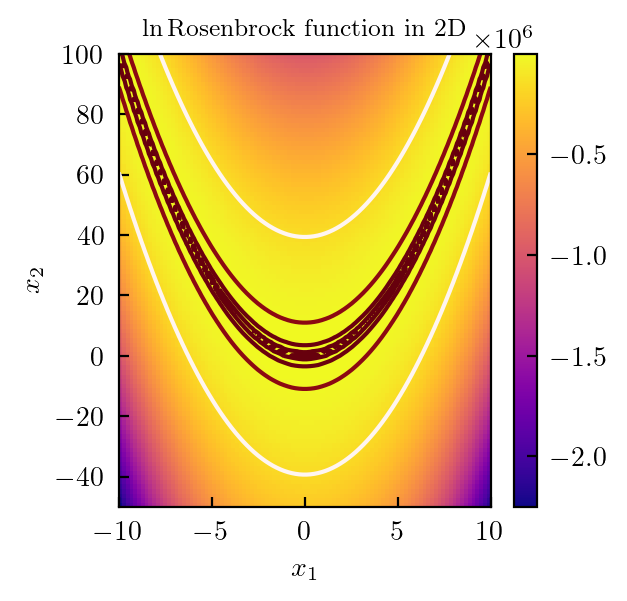

In [86]:
#xg, yg are 2D "grids" of x and y generated by meshgrid
# rg is 2D array with values of the Rosenbrock function for xg-yg grid

# contour levels; fairly arbitrary choice here, just to show the range of function values.
levs = rg.max() / np.exp(-0.15*np.arange(5,10)**2)

plot_color_map(x1g, x2g, rg, xlim=[xmin,xmax], ylim=[ymin,ymax], 
                   xlabel = r'$x_1$', ylabel = '$x_2$', cmap='plasma', colorbar=True, 
                   plot_title=r'$\rm \ln Rosenbrock\ function\ in\ 2D$', contours=True, contcmap='Reds', 
                   levels = levs[::-1], figsize=3.0)

In [87]:
ndim = 2 # dimensionality of the distribution
nsteps = 1000000 # number of steps to make
x0 = np.random.rand(ndim) # initial position
step = 1. # step size

args = [] # parameters of the Gaussian
# run simple MCMC 
chain = np.asarray(mcmc_simple(x0, nsteps, step, lnrosenbrock, *args))

/Users/panyue/opt/anaconda3/envs/py23/lib/python3.7/site-packages/ipykernel_launcher.py:51: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/Users/panyue/opt/anaconda3/envs/py23/lib/python3.7/site-packages/ipykernel_launcher.py:51: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
/Users/panyue/opt/anaconda3/envs/py23/lib/python3.7/site-packages/ipykernel_launcher.py:62: UserWarning: Log scale: values of z <= 0 have been masked


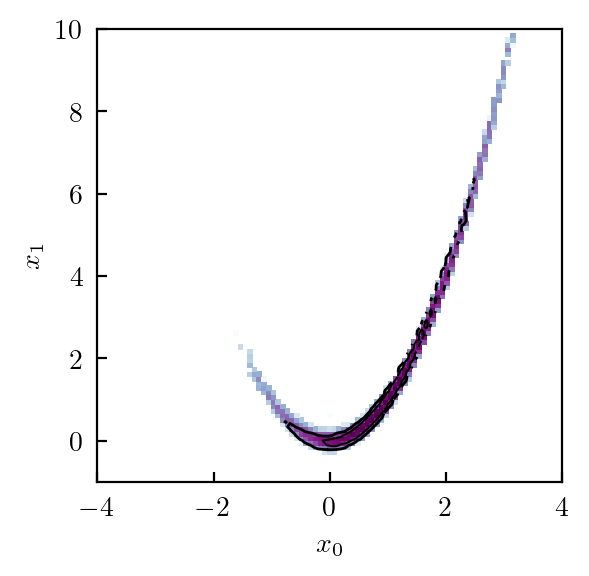

In [88]:
# define levels to plot (fractions of samples enclosed by the contours)
conflevs = [0.6827, 0.9545] # 1-sigma and 2-sigma contours

# plot distribution of MCMC samples as a 2d histogram with contours
# in the $x_0-x_1$ plane, where $x_0$ and $x_1$ are 2 Gaussian variables
# chain[:,0], chain[:,1] access sample values of two variables separately
plot_2d_dist(chain[:,0], chain[:,1], xlim=[-4,4], ylim =[-1,10], nxbins=100, nybins=100, 
             clevs=conflevs,  xlabel='$x_0$', ylabel='$x_1$', figsize=(3,3))

In [89]:
def plot_trace(x, figsize=3):
    try:
        nsteps, ndims = np.shape(x)[0], np.shape(x)[1]
    except:
        nsteps, ndims = np.shape(x)[0], 1
        
    plt.figure(figsize=(figsize,figsize))
    for d in range(ndims):
        if ndims == 1:
            plt.plot(np.arange(0,nsteps,1), x, lw=0.5, c='darkslateblue', label='d={:d}'.format(d))
        else:
            plt.plot(np.arange(0,nsteps), x[:,d], lw=0.5, c='darkslateblue', label='d={:d}'.format(d))
    plt.ylabel(r'$x$') # label axis 
    plt.xlabel(r'step number')
    plt.show()    

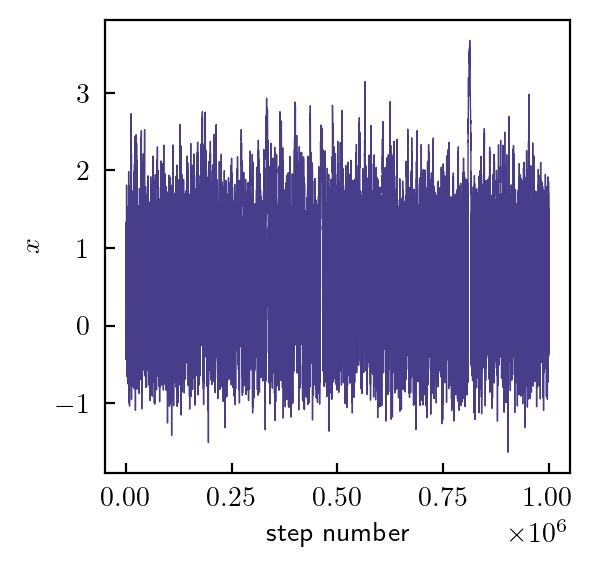

In [90]:
plot_trace(chain[:,0])

In [91]:
for i in range(ndim):
    tcorr = compute_tcorr(chain[:,i], 10000)[0]
    print('auto-correlation length for dimension {:d} = {:.3f}'.format(i, tcorr))

auto-correlation length for dimension 0 = 514.056
auto-correlation length for dimension 1 = 948.647


It helps to look at the <a href="http://chi-feng.github.io/mcmc-demo/">visualizations</a> of the MCMC sampling process to understand what's going on during sampling.

### <font color='darkblue'>Ensemble MCMC sampling

For example, Goodman & Weare (2010) MCMC sampling algorithm (implemented in <tt>emcee</tt> code) or Differential Evolution MCMC sampling algorithm (more on this next week)
    
<center>
<img width=500 src="https://astrobites.com/wp-content/uploads/2012/02/stretchmove-300x204.png"></img>

In [92]:
import emcee

ndim, nwalkers, nsteps = 2, 50, 10000

# initialize walkers
p0 = 1. + np.random.normal(scale=0.1, size=ndim * nwalkers).reshape((nwalkers, ndim))

# initialize MCMC sample
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnrosenbrock, args=[])

# run for a given nsteps
pos, prob, state = sampler.run_mcmc(p0, nsteps)

# get chain
chain = sampler.chain

/Users/panyue/opt/anaconda3/envs/py23/lib/python3.7/site-packages/ipykernel_launcher.py:51: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/Users/panyue/opt/anaconda3/envs/py23/lib/python3.7/site-packages/ipykernel_launcher.py:51: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
/Users/panyue/opt/anaconda3/envs/py23/lib/python3.7/site-packages/ipykernel_launcher.py:62: UserWarning: Log scale: values of z <= 0 have been masked


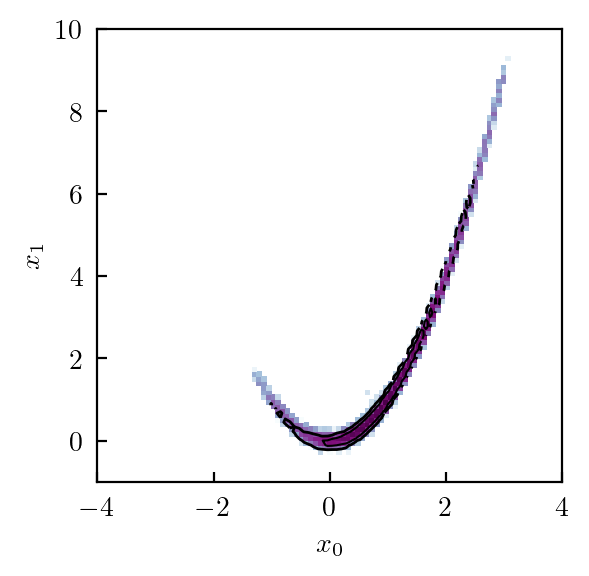

In [93]:
# define levels to plot (fractions of samples enclosed by the contours)
conflevs = [0.6827, 0.9545]

# plot distribution of MCMC samples as a 2d histogram with contours
# in the $x_0-x_1$ plane, where $x_0$ and $x_1$ are 2 Gaussian variables
# chain[:,0], chain[:,1] access sample values of two variables separately
plot_2d_dist(chain[:,:,0].flatten(), chain[:,:,1].flatten(), xlim=[-4,4], ylim =[-1,10], nxbins=100, nybins=100, 
             clevs=conflevs,  xlabel='$x_0$', ylabel='$x_1$', figsize=(3,3))

In [94]:
print(np.shape(np.unique(chain[:,:,0])))

(204758,)


In [95]:
# compute tcorr
for i in range(ndim):
    tcorr = compute_tcorr(chain[:,:,i].flatten(), 10000)[0]
    print('auto-correlation length for dimension {:d} = {:.3f}'.format(i, tcorr))

auto-correlation length for dimension 0 = 274.172
auto-correlation length for dimension 1 = 237.898


### <font color='darkblue'>Using MCMC in the Maximum Likelihood and Bayesian sampling</font>

In model "fitting" of a set of measurement, "best-fit" model parameters are those that maximize a statistical likelihood function or the posterior pdf in the Bayesian approach. 

MCMC method is often used to sample the likelihood distribution or posterior pdf for finding "best-fit" model parameter and their confidence regions. 

Here we will consider an example of fitting a linear model to a set of measurements. 

### <font color='darkblue'>The maximum likelihood method</font>

Suppose our model for the distribution of data points (measurements) of some quantities $x$ and $y$ in the $x-y$ plane is $y_m=bx +c + \sigma$, where $\sigma$ is the random number drawn from the Gaussian pdf with zero mean and standard deviation $\sigma$. 

This model assumes that uncertainties of measurements in both $x$ and $y$ measurements, $\sigma_x$ and $\sigma_y$, can be described by Gaussian pdfs. In this case, the overall uncertainty of the difference between measurement $(x,y)$ and model prediction $y_{\rm m}=bx + c$ is the uncertainty of the residual $r=y-bx-c$, which by propagation of error is $\sigma_r\approx \sqrt{\sigma_y^2 + b^2\sigma_x^2}$. 

In [96]:
def generate_mock_data(xlims, ex, ey, eboost=1., btrue=3, ctrue=3.481, nr = 2000):
    xr = np.random.uniform(xlims[0], xlims[1], size=nr) 

    exr = np.random.normal(scale=ex, size=nr)
    eyr = np.random.normal(scale=ey, size=nr)

    yr = btrue * xr + ctrue + eyr*eboost
    xr = xr + exr
    
    return xr, exr, yr, eyr

In [97]:
def plot_mock_data(xr, yr, exr=None, eyr=None, 
                   btrue=None, ctrue=None, figsize=(5,5)):
    # plot mock data
    plt.figure(figsize=figsize)
    plt.errorbar(xr, yr, xerr=exr, yerr=eyr, fmt='o', alpha=0.5, color='darkslateblue')
    plt.xlabel(r'$x$')
    plt.ylabel('$y$')
    xf = np.linspace(xr.min(), xr.max(), 10)
    plt.plot(xf, btrue * xf + ctrue, '--', c='orangered', label='true model')
    plt.legend(loc='best', frameon=False)
    plt.show()

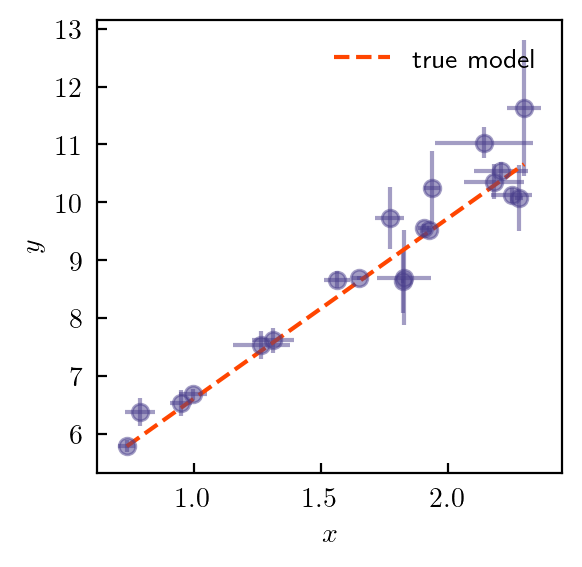

In [98]:
# generate mock data with a given slope and intercept
nr = 20 # number of data points to generate
btrue, ctrue = 3.11, 3.5
ex, ey = 0.1, 0.5
xr, exr, yr, eyr = generate_mock_data([0.7, 2.5], ex, ey, btrue=btrue, ctrue=ctrue, nr=nr)

plot_mock_data(xr, yr, exr=exr, eyr=eyr, btrue=btrue, ctrue=ctrue, figsize=(3,3))

The model defines the probability density function for a single measurement $x_i, y_i$, with Gaussian uncertainty in $y_i$ given by $\sigma_i$: 

$$p(y_i\vert y_m)=p(y_i\vert b,c)={1\over \sqrt{2\pi \sigma^2_{i}}}\,\exp\left[-{1\over 2}\,\frac{(y_i-y_m)^2}{\sigma_{i}^2}\right]$$

and thus probability or *likelihood*  $p(y_i\vert b,c)dy$ that measured value $y_i$ is expected in the interval $[y_i,y_i+dy]$, given the model and its parameters. 

Here $dy$ is some small *constant* interval value. 

### <font color='darkblue'>The likelihood </font>

If we assume that different measurement pairs $(x_i,y_i)$ with different $i$ are independent (i.e., uncorrelated), the probability of all the $y$ measurements given the model and its parameter value is given by the product of individual probabilities: 

$$p({\rm data}\vert {\rm model}) = {\rm probability_{\rm y_0}}\times {\rm probability_{\rm y_1}}\,\ldots\,\times\,{\rm probability}_{y_{n-1}}$$

or, more mathematically: 

$$P({\rm data}\vert {\rm model}) = P(\vec{y}\vert b,c) = p(y_0\vert b,c)\,p(y_1\vert b,c)\,\ldots\, p(y_{n-1}\vert b,c)\,dy^n$$

where $\vec{y}=[y_0,y_1,\ldots,y_{n-1}]$ is a vector of $y$ measurement values. 

The probability $p({\rm data}\vert {\rm model})$ is called ***the likelihood function*** (or just ***the likelihood***) of measurement data given the model and is often denoted by $L$: 

$$L({\rm data}\vert {\rm model}):= p({\rm data}\vert {\rm model})$$

### <font color='darkblue'>The maximum likelihood method</font>

consists of finding the combination of model parameters ($b$ and $c$ in this case) that ***maximize the value of the likelihood***. In other words, the parameters $\tilde{b}$, $\tilde{c}$ for which model is assumed to be the best description of the data are those for which 

$$L(\vec{y}\vert \tilde{b},\tilde{c})= L_\max=\max\limits_{b,c}L(\vec{y}\vert b,c)$$

Given that the likelihood is a product of many Gaussian pdfs (each corresponding to a different measurement), it can become numerically very small and cause underflow of floating pont operations. For this reason, in this method the natural logarithm of $L$, $\ln L$ is used instead of $L$. This does not change the result, because $\ln L$ is maximized when $L$ is maximized and vice versa. 

$$\ln L(\vec{y}\vert b,c) = \ln \left\{{1\over \sqrt{2\pi \sigma^2_{0}}}\,\exp\left[-{1\over 2}\,\frac{(y_0-y_m)^2}{\sigma_{0}^2}\right]\times \ldots\times {1\over \sqrt{2\pi \sigma^2_{n-1}}}\,\exp\left[-{1\over 2}\,\frac{(y_{n-1}-y_m)^2}{\sigma_{n-1}^2}\right]\right\}$$

Remembering that $\ln xy = \ln x + \ln y$, we have multiple products here...  

First (taking into account that $\ln e^x = x\ln e=x$): 

$$\ln \left\{\frac{1}{\sqrt{2\pi} \sigma_{0}}\,\exp\left[-{1\over 2}\,\frac{(y_0-y_m)^2}{\sigma_{0}^2}\right]\right\}= \ln{1\over \sqrt{2\pi}} - \ln\sigma_{0}-{1\over 2}\,\frac{(y_0-y_m)^2}{\sigma_{0}^2}$$

$$\ln L(\vec{y}\vert b,c) = n\ln{1\over \sqrt{2\pi}} - \sum\limits_{i=0}^{n-1}\ln\sigma_{i}-{1\over 2}\,\sum\limits_{i=0}^{n-1}\frac{(y_i-y_m)^2}{\sigma_{i}^2}=n\ln{1\over \sqrt{2\pi}} - {1\over 2} \,\sum\limits_{i=0}^{n-1}\ln\sigma_{i}^2-{1\over 2} \,\sum\limits_{i=0}^{n-1}\left(\frac{r_i}{\sigma_{i}}\right)^2,$$

$\ln{n\over \sqrt{2\pi}}$ is just a constant for a given data set so don't really need to be included for MCMC sampling, which does not depend on the constant normalization of the distribution.

The functions below generate a mock data set that follows a linear relation with specified slope and intercept (<tt>btrue, ctrue</tt>) and uncertainties in both $x$ and $y$ variables. 

Function below computes $\ln L$ given by expression above for input values of $c$ and $b$ and data set passed through <tt>args</tt>

In [99]:
def loglin_like(p, *args):
    """
    ln of linear model likelihood

    Parameters:
    -----------
    p - real 1d numpy vector of size 3 
        values of the model parameters, c, m, intrinsic scatter in y direction
    args is a list of numpy arrays in this order: 
        x - real 1d numpy vector
            x values of data, array size = number of data points ndata
        y - real 1d numpy vector
            y values of data of the same size as x 
        sigx - real 1d numpy vector of size x
            Gaussian st dev of x
        sigy - real 1d numpy vector of size 
            Gaussian st dev of y

    Returns:
    --------
    a real number 
        ln(Likelihood of linear model with intrinsic Gaussian scatter in y direction)
    """
    x, y, sigx, sigy = args
    sigtot2 = sigy**2 + (p[1]*sigx)**2

    # 1/sqrt(2.*pi) factor can be omitted from the likelihood because it does not depend on model parameters
    return np.sum(-0.5 * (np.log(sigtot2) + (y - p[0] - p[1]*x)**2 / sigtot2))
    

In [100]:
ndim = 2
nsteps = 100000
x0 = [3.5, 3.] # start at the true values of the parameters
step = 0.1

args = [xr, yr, exr, eyr]
chain = np.asarray(mcmc_simple(x0, nsteps, step, loglin_like, *args))

/Users/panyue/opt/anaconda3/envs/py23/lib/python3.7/site-packages/ipykernel_launcher.py:51: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/Users/panyue/opt/anaconda3/envs/py23/lib/python3.7/site-packages/ipykernel_launcher.py:51: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
/Users/panyue/opt/anaconda3/envs/py23/lib/python3.7/site-packages/ipykernel_launcher.py:62: UserWarning: Log scale: values of z <= 0 have been masked


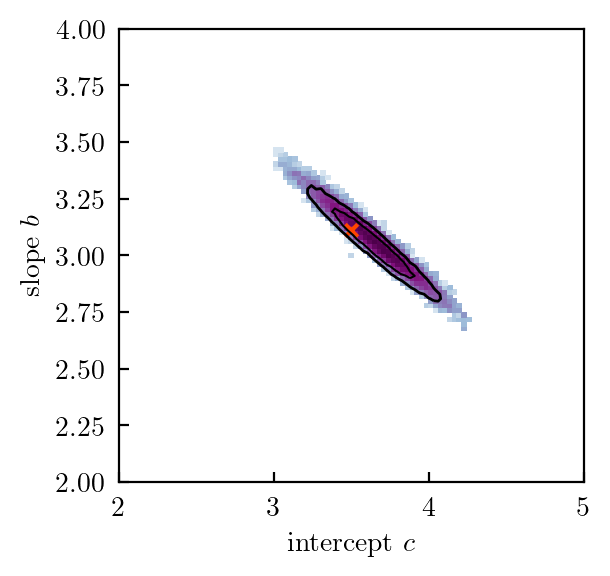

In [101]:
conflevs = [0.6827, 0.9545]

plot_2d_dist(chain[:,0], chain[:,1], xlim=[2,5], ylim =[2.,4], 
             nxbins=100, nybins=100, 
             clevs=conflevs, xpmax=ctrue, ypmax=btrue, 
             xlabel=r'${\rm intercept}\ c$', 
             ylabel=r'${\rm slope}\ b$', figsize=(3,3))

We can see that distribution of $b$ and $c$ values looks like a 2-dimensional Gaussian. The true value of the parameters is close to the peak of the distribution. This means that we *infered* parameter values from the mock data without bias. The values of $b$ and $c$ of the chain element that maximizes the likelihood can be taken as "best-fit" parameter values. If the distribution is close to Gaussian (symmetric) a simple median of the values can be used as a parameter estimates. These will be somewhat different from true values because parameter inference has uncertainty that is reflected in the width of the distribution above.  

The confidence intervals of $b$ and $c$ can be obtained by determined by finding their value range that encloses a given fraction of the samples. For example, contours in the plot above enclose $68.27%$ and $95.45%$ of the samples are this is what usually referred to as $1-\sigma$ and $2-\sigma$ contours (one can add more contours if outer parts of the distribution are well sampled. 

In [53]:
def clims(a):
    x1 = 0.5*(100.-a)
    return x1, a + x1

def chain_stats(x, param_name='x'):
    """
    print mean, median, and confidence intervals for samples for a chain of sampled values
    for a *single* parameter
    """
    xmed = np.median(x); xm = np.mean(x); xsd = np.std(x)
    a = 68.268; 
    x1, x2 = clims(a)
    xcfl11 = np.percentile(x,x1); xcfl12 = np.percentile(x,x2)
    a = 95.452
    x1, x2 = clims(a)
    xcfl21 = np.percentile(x,x1); xcfl22 = np.percentile(x,x2)
    dashedline = '-------'
    print('============ statistics for {:s} ============'.format(param_name))
    print('mean, median = %.3f, %.3f, st.dev=%.4f'%(xm, xmed, xsd))
    print('68 perc interval = %.3f, %.3f'%(xcfl11, xcfl12))
    print('95 perc interval = %.3f, %.3f'%(xcfl21, xcfl22))


In [54]:
chain_stats(chain[:,0], param_name='intercept')
chain_stats(chain[:,1], param_name='slope')

============ statistics for intercept ============
mean, median = 3.632, 3.637, st.dev=0.2268
68 perc interval = 3.402, 3.855
95 perc interval = 3.169, 4.073
============ statistics for slope ============
mean, median = 3.029, 3.026, st.dev=0.1039
68 perc interval = 2.927, 3.134
95 perc interval = 2.826, 3.242


### <font color='darkblue'>Importance of the starting point and burn-in

You may have noticed that the MCMC sampling above was started at the true values of the parameters. 
This is the luxury we may not have. 
    
Recalculation below shows what happens when we start at values pretty far from the true ones. 

In [55]:
ndim = 2
nsteps = 100000
x0 = [0, 1.] # start at the true values of the parameters
step = 0.1

args = [xr, yr, exr, eyr]
chain = np.asarray(mcmc_simple(x0, nsteps, step, loglin_like, *args))

/Users/panyue/opt/anaconda3/envs/py23/lib/python3.7/site-packages/ipykernel_launcher.py:51: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/Users/panyue/opt/anaconda3/envs/py23/lib/python3.7/site-packages/ipykernel_launcher.py:51: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
/Users/panyue/opt/anaconda3/envs/py23/lib/python3.7/site-packages/ipykernel_launcher.py:62: UserWarning: Log scale: values of z <= 0 have been masked


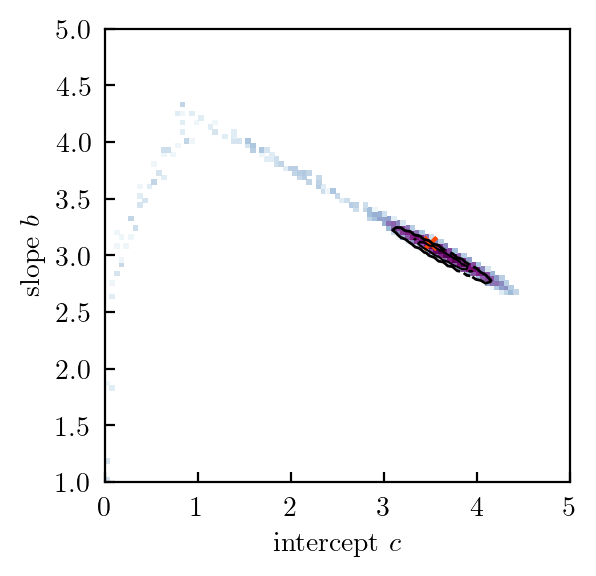

In [56]:
conflevs = [0.6827, 0.9545]

plot_2d_dist(chain[:,0], chain[:,1], xlim=[0,5], ylim =[1.,5], 
             nxbins=100, nybins=100, 
             clevs=conflevs, xpmax=ctrue, ypmax=btrue, 
             xlabel=r'${\rm intercept}\ c$', 
             ylabel=r'${\rm slope}\ b$', figsize=(3,3))

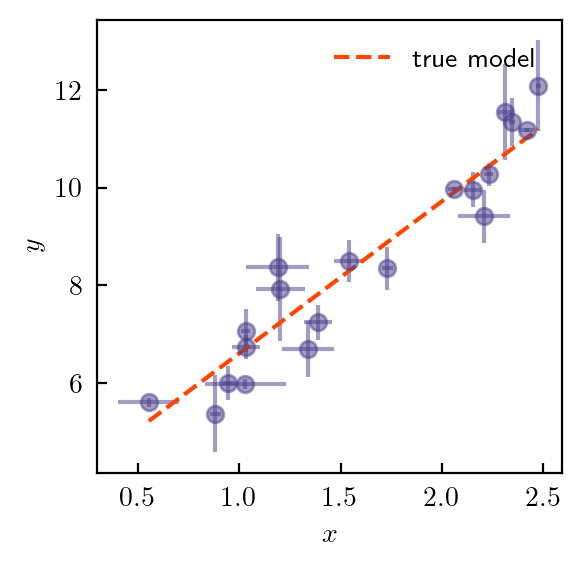

In [57]:
# generate mock data with a given slope and intercept
nr = 20 # number of data points to generate
btrue, ctrue = 3.11, 3.5
ex, ey = 0.1, 0.5
xr, exr, yr, eyr = generate_mock_data([0.7, 2.5], ex, ey, eboost=1., btrue=btrue, ctrue=ctrue, nr=nr)

plot_mock_data(xr, yr, exr=exr, eyr=eyr, btrue=btrue, ctrue=ctrue, figsize=(3,3))

In [58]:
ndim = 2
nsteps = 100000
x0 = [3.5, 3.] # start at the true values of the parameters
step = 0.1

args = [xr, yr, exr, eyr]
chain = np.asarray(mcmc_simple(x0, nsteps, step, loglin_like, *args))

/Users/panyue/opt/anaconda3/envs/py23/lib/python3.7/site-packages/ipykernel_launcher.py:51: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/Users/panyue/opt/anaconda3/envs/py23/lib/python3.7/site-packages/ipykernel_launcher.py:51: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
/Users/panyue/opt/anaconda3/envs/py23/lib/python3.7/site-packages/ipykernel_launcher.py:62: UserWarning: Log scale: values of z <= 0 have been masked


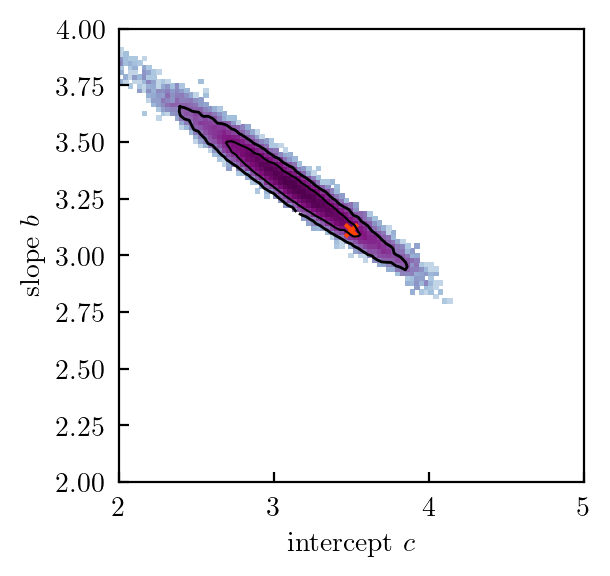

In [59]:
conflevs = [0.6827, 0.9545]

plot_2d_dist(chain[:,0], chain[:,1], xlim=[2,5], ylim =[2.,4], 
             nxbins=100, nybins=100, 
             clevs=conflevs, xpmax=ctrue, ypmax=btrue, 
             xlabel=r'${\rm intercept}\ c$', 
             ylabel=r'${\rm slope}\ b$', figsize=(3,3))

We can see that the chain recovers, but there is a fairly sizeable initial portion of the chain where samples do not follow the Gaussian pdf. This is the "burn-in" part of the chain. If it is not removed, it can potentially bias our estimates of quantities such as mean values of parameters. 

Burn-in can be minimized if we start from the initial values of parameters that are close to the maximum of the distribution. Thus, it helps to know where this maximum is. Finding extrema of functions is handled by ***optimization methods***, which we will discuss later. 

## <font color='darkblue'>Bayesian approach
    
Bayesian approach is based on 
**the Bayes theorem**:

$$p({\rm model\vert data})=\frac{p({\rm data}\vert {\rm model})\,p({\rm model})}{p({\rm data})}$$


which, in turn, is a consequence of the usual chain rule of joint probability of data and model: 

$$p({\rm data,\ model}) = p({\rm model}\vert {\rm data})\,p({\rm data}) = p({\rm data}\vert {\rm model})\,p({\rm model})$$

As mentioned before, the probability of data given the model $p({\rm data}\vert {\rm model})$ is usually called ***the likelihood*** in statistical analyses: 

$$L({\rm data}\vert {\rm model}) := p({\rm data}\vert {\rm model})$$


So Bayesian approach differs from the maximum likelihood method by multiplication of the likelihood by the prior pdf's of model parameters. 

###  <font color='darkblue'>Note:
    
When dealing with conditional probabilities, it's useful to remember that
probability distributions have dimensions to make sure that they are used correctly. A given pdf measures *density* of probability per length of the interval, so $p(x)$ has dimension of $x^{-1}$ so that $p(x)dx$ is dimensionless and gives probability of $x$ to be in $[x,x+dx]$. Likewise, $p(x,y)$ has dimensions of $x^{-1}y^{-1}$.

Conditional pdf notation may be a bit confusing in this regard, but the key is that dimensionality of pdf only depends on the variables to the left of $\vert$, so $p(x|y)$ has dimension $x^{-1}$, $p(x,y|z)$ has dimensions $x^{-1}y^{-1}$ etc. 
    
It's useful to remember this, because then it can be used to check expressions involving probability. 
Thus, for example, $\int p(x|y)dx$ is a dimensionless probability, if $p$ is a properly normalized pdf, while $\int p(x|y)dy$ is not because it has dimensions of $[y/x]$.

The Bayes theorem reflects dimensionalities of the pdfs that enter into its expression. For example:

$$p(x|y) = \frac{p(y|x)p(x)}{p(y)}.$$

If we compute dimensions of pdf on the left and expression on the right hand side, they will both have dimension of $x^{-1}$. 

###  <font color='darkblue'>Prior distributions for the linear model


If we have good reasons to think that slope and intercept should be within a given range, then priors corresponding to that range should be defined. However, if we don't really know what values to expect, then prior distributions can be inferred via the following considerations. 

 Slope $b$ varies from zero to infinity, and uniform prior in $b$ would thus assign a lot of probability to large $b$ values, which can bias inferred $m$ values high. Most natural assumption is thus that angle formed by the line and say $x$ axis is uniformly distributed  $\alpha\in[-\pi/2,\pi/2]$, where $b=\tan\alpha$. Differential $db=d\alpha/\cos^2\alpha=d\alpha(1+b^2)$. Thus, uniform prior on $\alpha$ implies 
 
$$p(\alpha)d\alpha={\rm const}\ \ \ \rightarrow\ \ \ \ p(b)\propto \frac{db}{1+b^2}.$$
 
A somewhat trickier, but not overly complicated consideration (see your notebook) also suggests that the prior pdf of $c$ should be 

$$p(c)\propto \frac{1}{\sqrt{1+b^2}},$$

so that 

$$p(c,b)\propto \frac{1}{(1+b^2)^{3/2}}.$$

**Note:** it is natural to assume uniform prior not in $c$, because $c$ depends on the particular choice of axis $y$, which will change if reference frame is rotated, but distance from the line to the origin $(x,y)=(0,0)$, $c_\perp=c\cos\alpha=c/\sqrt{1+b^2}$, which is invariant to rotation of the frame. Then $dc_\perp = dc/\sqrt{1+b^2}$ and uniform prior in $dc_\perp$ implies 

$$p(c)\propto \frac{1}{\sqrt{1+b^2}},$$

so that 

$$p(c,b)\propto \frac{1}{(1+b^2)^{3/2}}.$$

This prior can also be formally derived by requiring that $p(c,b)$ functional form is symmetric to switch of $x$ and $y$ axes. Prior pdfs above are expressed as proportionalities without normalization constants. These constants do not matter for MCMC sampling because it is not sensitive to the constant normalization of the sample distribution. 


### <font color='darkblue'>Posterior pdf
    
In the Bayesian approach instead of finding the maximum of and sampling the likelihood function we sample the posterior pdf given by the product of the likelihood function and prior pdfs of parameters. 
    
Thus, for the linear model posterior pdf is:
    
$$\pi(b,c\vert \vec{d}) = L(\vec{d}\vert b,c) p(b)p(c).$$
    
where $\vec{d}$ includes all data $\vec{d}=\{\vec{x},\vec{y},\vec{\sigma}_x,\vec{\sigma}_y\}$. This posterior distribution is not properly normalized to be a pdf because we ignore factor $Z=1/p(\vec{d})$.  This factor is called *the evidence* in Bayesian analysis. MCMC sampling is not sensitive to distribution normalization, but calculation of evidence is important for Bayesian model comparison (see below).  
    
As for likelihood, for numerical stability we sample $\ln\pi$ instead of $\pi$:

$$\ln \pi(b,c\vert \vec{d}) = n\ln{1\over \sqrt{2\pi}}  - {1\over 2} \,\sum\limits_{i=0}^{n-1}\ln\sigma_{i}^2-{1\over 2} \,\sum\limits_{i=0}^{n-1}\left(\frac{r_i}{\sigma_{i}}\right)^2 + \ln p(c) + \ln p(b),$$

The constant factor $n\ln{1/\sqrt{2\pi}}$ is not important for MCMC sampling itself, which is not sensitive to constant normalization factors, but it is important for estimating Bayesian evidence or BIC criterion described below. 

### <font color='darkblue'>Model comparison in Bayesian analysis

#### The rest of this notebook is optional for undergraduate students
    
We often have competing models that can be aiming to describe the data. A simple example, is that if we don't know the form of the underlying trend we can consider a linear model like above and a quadratic model $y=ax^2 + bc + c$ as description for the data. How can we decide which model is better?
    
Two models are compared in the Bayesian analysis, by comparing their *odds*, where odds $O$, is defined as the probability given by the product of evidence and whatever prior probability the model had: 

$$
O(\mathcal{M})\equiv E(\mathcal{M})p(\mathcal{M}\vert I).
$$

For example, if our current personal prior for the MOND model, $p(\mathcal{M}=\mathrm{MOND}\vert I)$ is very low, say $10^{-6}$, it needs to accumulate a large number of high evidences $E_i$ for a wide range of data, $\vec{d}_i$ to overcome the low value of starting bias and to get sizeable odds of being correct. However, even this process itself requires the MOND model to produce likelihoods for such observations, which is usually possible for a full-fledged predictive theory, but is often problematic for an ansatz like MOND.
 
By convention Bayesians consider compare two models, $\mathcal{M}_1$ and $\mathcal{M}_2$, using the {\it odds ratio}:

$$
 O_{21} =\frac{O(\mathcal{M}_2)}{O(\mathcal{M}_2)}=\frac{E(\mathcal{M}_2)p(\mathcal{M}_2\vert I)}{E(\mathcal{M}_1)p(\mathcal{M}_1\vert I)}\equiv B_{21}\frac{p(\mathcal{M}_2\vert I)}{p(\mathcal{M}_1\vert I)},
$$

 where $B_{21}\equiv E(\mathcal{M}_2)/E(\mathcal{M}_1)$ is called the *Bayes factor*. 


### <font color='darkblue'>Logic of the odds ratio

 The logic of the odds ratio can be grasped if we consider the case of likelihood given by the multi-variate Gaussian with flat prior pdf of parameters, $x_i$, over ranges $\Delta_{x_i}$: $p(x_i)=1/\Delta_{x_i}$. In this case the integral which gives the evidence will be proportional to $p_{\rm max}\sigma_{x_i}/\Delta_{x_i}$, where $\sigma_{x_i}$ is the rms of $x_i$. The better data constrains parameter $x_i$, the smaller the ratio $\sigma_{x_i}/\Delta_{x_i}$, although the overall evidence will generally in this case. For each added parameter, the evidence will be weighed by the factor $\sigma_{x_i}/\Delta_{x_i}$. If model adds parameters that are not constrained by the data, $\sigma_{x_i}\sim \Delta_{x_i}$, the evidence probability is not penalized for such additional parameters. However, if additional parameters are well constrained, each of them will penalize the evidence by multiplying it by its ratio $\sigma_{x_i}/\Delta_{x_i}$. Thus, to justify the additional parameters, the penalty needs to be compensated by increase of $p_{\rm max}$ and/or by larger prior ratio $p(\mathcal{M}_+\vert I)/p(\mathcal{M}\vert I)$ of model with more parameters, $\mathcal{M}_+$, compared to the fiducial model, $\mathcal{M}$. This is analogous to the well-known ``Occam's razor'' principle, which states that out of two models explaining observations equally well, a simpler model (i.e., model with fewer parameters) should be preferred.  

### <font color='darkblue'> Bayesian Information Criterion (BIC) 

To compare models with posteriors sampled by MCMC amounts to evaluating the integral shown above. Sometimes it is difficult because accuracy of MCMC integration has low accuracy and we may not have sufficient number of samples to sample tails of the distribution sufficiently well. 
    
For this reason, instead of evaluating evidence properly the Bayesian Information Criterion (BIC) is often used as a short cut. The idea is that when parameters are well constrained the posterior is approximated by a multi-variate Gaussian can be used to approximate evidence. Namely, if we use the approximation of the evidence interval above as 
$$
E\approx p_{\rm max}\left(\frac{\sigma_{x_i}}{\Delta_{x_i}}\right)^d,
$$
where $p_{\rm max}$ is the maximum value of the likelihood among the positions of all $N$ data points, $d$ is the number of model parameters, $\sigma_{x_i}$ is the width of the posterior in $i$-th variable and $\Delta_{x_i}$ is effective width of the prior pdf in the same variable. 
    
If we assume that the widths of the posterior scale with the number of data points $N$ as $\sigma_{x_i}=c_i/\sqrt{N}$, and that for $N=1$ the posterior has the width of the prior, i.e. $c_i\sim \Delta_{x_i}$, we get $E\approx p_{\rm max} N^{-d/2}$.

The BIC estimator is defined as
$$
\mathrm{BIC} :=-2\ln E  \approx d\ln N - 2\ln p_{\rm max}
$$
    
Given its assumptions, BIC should be a good approximation for evidence when parameters are well constraibed (posterior pdf is close to multivariate Gaussian pdf), and will progressively less accurate is posterior pdf is not close to Gaussian.


### Recommended reading

* S 3.1-3.8 and S 2 of the <a href="http://adsabs.harvard.edu/abs/2017ARA%26A..55..213S">ARA&A review</a> by Sanjib Sharma on MCMC methods for Bayesian data analysis in astronomy.

